# Sea Ice Indicators Update: More trend analyses

##### 2021-06-03

This update includes a look at the corrected Steele ice season length maps, along with trends of ice extent for the Greenland and Bering seas and a set of indicator trends of a point location in the Greenland Sea, discussed at our meeting on 5/28/21.

## Corrected ice season length maps

The previous iterations of these had errors in the Steele indicators maps. The first error was corrected (sent over email) but there remained an error that was causing unrealistically large differences in mean ice season length between adjacent pixels. That error has been corrected in this version: 

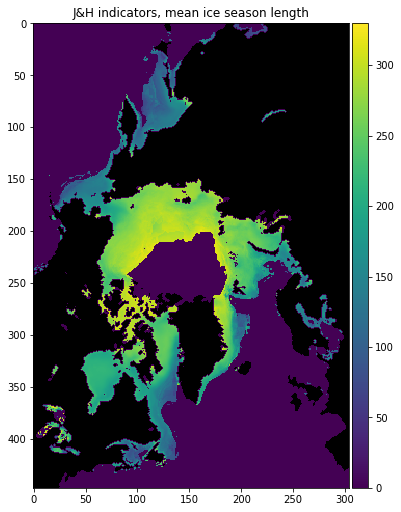

In [2]:
import copy
import os
import warnings
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from scipy import stats
import seaborn as sns
from rasterstats import zonal_stats
from shapely.geometry import Polygon
import rioxarray
from rasterio import plot
from pyproj import Transformer, crs
from datetime import datetime



def plot_season_length(ds, titles, landmask=None):
    """Count valid dates by metric and plot"""
    if "freezeup_start" in list(ds.variables):
        season_lengths = (ds["breakup_end"].values + 365) - ds["freezeup_start"].values
    else:
        # calculate ice season length for NSIDC-0747 data as
        # day of retreat minus day of advance
        dor = ds["DOR"].values.copy()
        doa = ds["DOA"].values.copy()
        invalid_mask = (dor <= 0) | (doa <= 0) 
        dor[invalid_mask] = np.nan
        doa[invalid_mask] = np.nan
        dor += 365
        season_lengths = dor - doa
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        plot_arr = np.nanmean(season_lengths, 0)
        
    plot_arr[np.isnan(plot_arr)] = 0
    plot_arr = np.ma.masked_where(landmask, plot_arr)
    plot_arr.data[plot_arr.mask] = np.nan
    
    # plot data
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_bad(color="black")
    plt.figure(figsize=(6,10))
    ax = plt.gca()
    im = plt.imshow(plot_arr, interpolation="none", cmap=cmap, vmin=0, vmax=330)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
    return plot_arr
    
    
base_dir = Path(os.getenv("BASE_DIR"))
# computed fubu dates fp
fubu_fp = base_dir.joinpath("nsidc_0051/outputs/nsidc_0051_1979-2019_fubu.nc")
# path to sample converted file to get landmask array
converted_fp = list(base_dir.joinpath("nsidc_0051/prepped").glob("*"))[0]

# load fubu dates netCDF
# set up meta data for saving GeoTIFFs
with rio.open(converted_fp) as src:
    # defined for global reference
    fubu_landmask = src.read(1) == 254
    # meta = src.meta

fubu_ds = xr.load_dataset(fubu_fp)

orac_fp = base_dir.joinpath("nsidc_0747", "arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc")
orac_ds = xr.load_dataset(orac_fp)

# title = "J&H indicators, mean ice season length"
# fubu_isl_arr = plot_season_length(fubu_ds, title, fubu_landmask)

orac_landmask = orac_ds["DOA"].values[0] == -4

title = "Steele indicators, mean ice season length"
orac_isl_arr = plot_season_length(orac_ds, title, orac_landmask)

## Ice extent trends

Trends of mean ice extent, computed as number of pixels having a sea ice concentration of > 15%. Presented for Greenland Sea and Bering Sea MAISE regions, for October - March. 

### Greenland sea

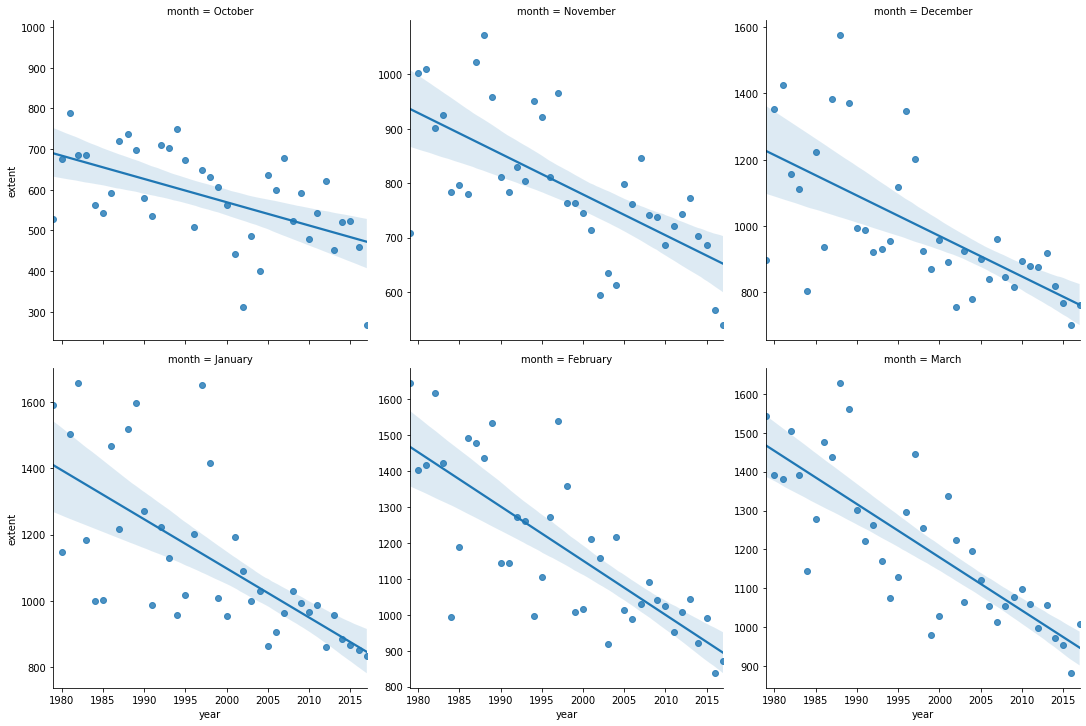

In [4]:
smoothed_fp = "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/nsidc_0051/smoothed/NetCDF/nsidc_0051_sic_nasateam_1978-2018_north_smoothed.nc"

with rio.open(smoothed_fp.replace("NetCDF", "GTiff").replace(".nc", ".tif")) as src:
    affine = src.transform
    crs = src.crs

def get_polygon(row):
    """Create shapely polygon object from row of 
    alternating lat/lon coords
    """
    df_di = {"lat": [], "lon": []}
    for idx, value in zip(row.index, row):
         
        if pd.isnull(value):
            df_di["lat"].append(df_di["lat"][0])
            df_di["lon"].append(df_di["lon"][0])
            break
        if "Lat" in idx:
            df_di["lat"].append(value)
        if "Lon" in idx:
            df_di["lon"].append(value)
            
    df = pd.DataFrame(df_di)
    
    return Polygon(list(zip(df.lon, df.lat)))

masie_fp = base_dir.joinpath("ancillary/MASIE_regions_polygon_vertices.xls")

df = pd.read_excel(masie_fp, skiprows=1)

polys = df[["Region Number Identifier", "Name"]].copy()
for index, row in df.iterrows(): 
    polys.loc[index, "geometry"] = get_polygon(row)

polys = gpd.GeoDataFrame(polys).set_crs(epsg=4326).to_crs(crs)

def compute_avg_extent(ds, polys, affine, month):
    """Compute the average yearly SIC extent for a given month and polygon"""
    # get the masked array of the region of interest
    # from first day sic array
    
    def return_marr(marr):
        """Used for getting masked array 
        from zonal_stats
        """
        return marr
    
    
    def zonal_extent(marr):
        arr = marr.data[~marr.mask]
        
        return np.sum(arr > 0.15)
    
    def run_zonal_extent(polys, arr, affine):
        zs = zonal_stats(
            polys, 
            arr, 
            affine=affine,
            nodata=-9999, 
            stats=["count"],
            add_stats={"extent": zonal_extent}
        )
        
        return [di["extent"] for di in zs]
    
    # iterate through year numbers and compute extent slices of months, take mean
    years = np.arange(1979, 2018)
    extents = []
    regions = []
    for year in years:
        sl = slice(
            pd.to_datetime(f"{year}-{month}-01"), 
            pd.to_datetime(f"{year}-{month}-01") + pd.DateOffset(months=1) - pd.DateOffset(1),
        )
        day_extents = np.array([
            run_zonal_extent(polys, arr, affine) 
            for arr in ds.sel(time=sl)["sic"].values
        ])

        _ = [extents.append(mean_extent) for mean_extent in day_extents.mean(axis=0)]
        _ = [regions.append(region_name) for region_name in polys.index.values]
        
    return pd.DataFrame({"year": np.repeat(years, len(polys)), "region": regions, "extent": extents})
        

regions = ["Bering Sea", "Greenland Sea"]
extent_polys = polys.set_index("Name").loc[regions]

smoothed_ds = xr.load_dataset(smoothed_fp)

extent_df = pd.DataFrame()
for month in [10, 11, 12, "01", "02", "03"]:
    month_extents = compute_avg_extent(smoothed_ds, extent_polys, affine, month)
    month_extents["month"] = datetime.strftime(datetime.strptime(f"1980-{month}-01", "%Y-%m-%d"), "%B")
    extent_df = extent_df.append(month_extents)

region = "Greenland Sea"
sns.set(font_scale=1.5)
sns.lmplot(x="year", y="extent", col="month", col_wrap=3, data=extent_df[extent_df["region"] == region], sharey=False)
plt.show()

### Bering Sea

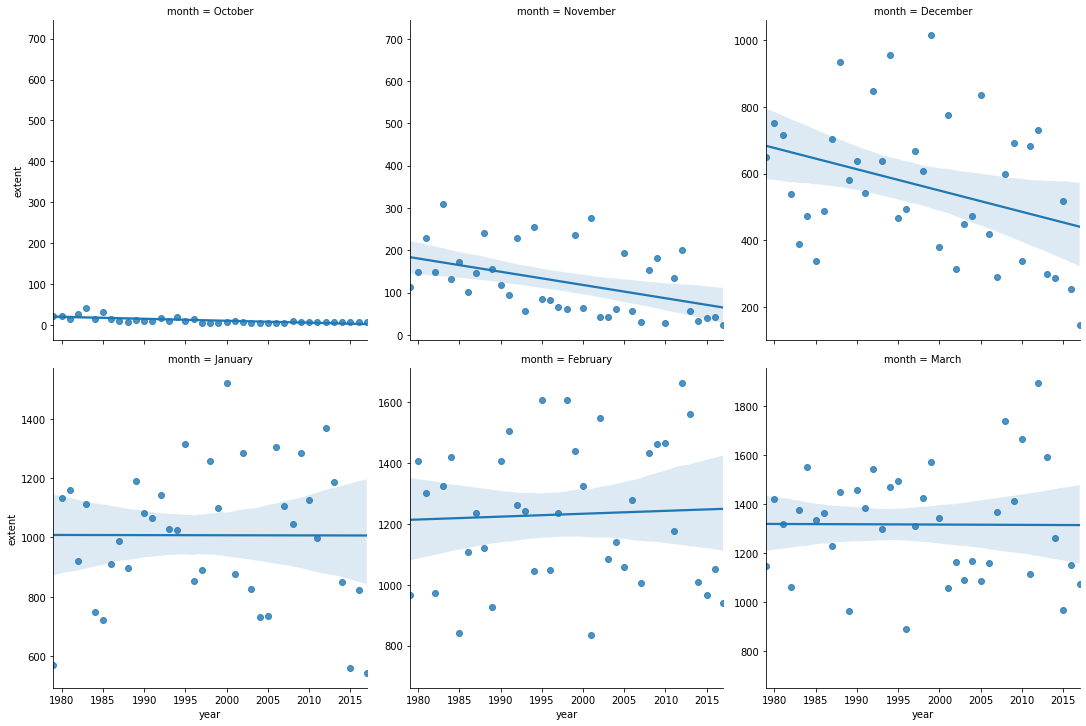

In [5]:
region = "Bering Sea"
sns.lmplot(x="year", y="extent", col="month", col_wrap=3, data=extent_df[extent_df["region"] == region], sharey=False)
plt.show()

## Indicators trends for pixels NE of Greenland

Here are the trends of indicators for some pixels in the Greenland Sea. The pixels used are:

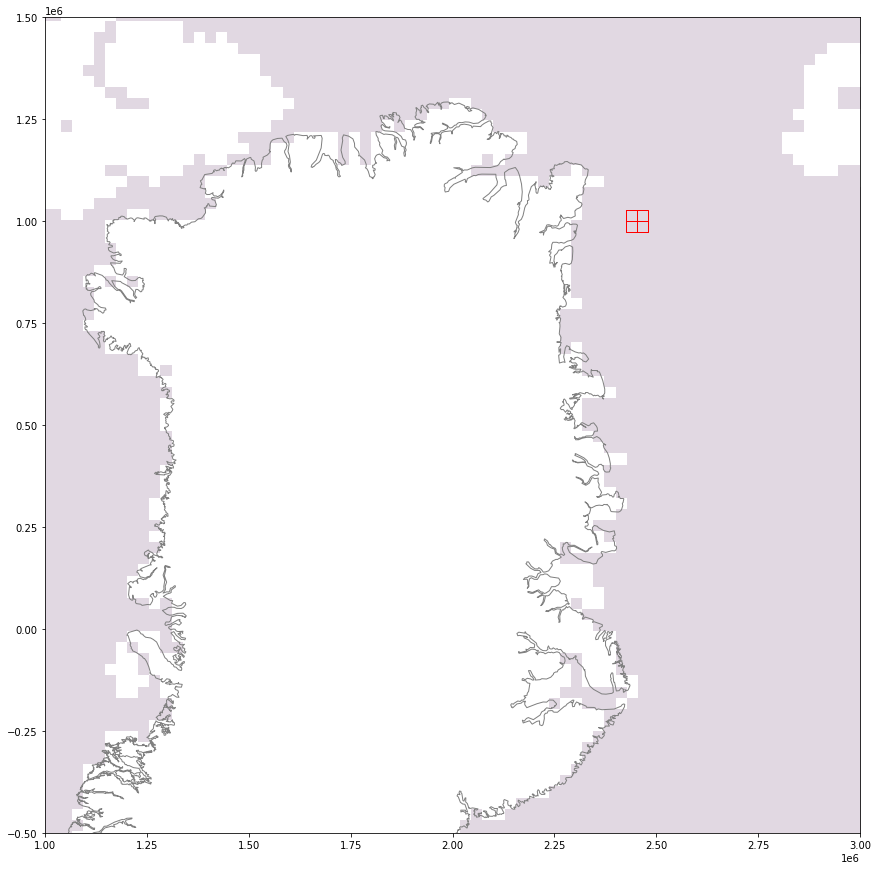

In [6]:
def get_xy_from_coords(fp, x, y, offsets):
    """shift is a list of tuples correpsonding to 
    a single pixel of interest (poi), each tuple contains
    the index shift from the base pixel to the poi
    as (x shift, y shift)
    
    returns list of center points of pixels corresponding
    to the offsets
    """
    row, col = src.index(x, y)

    return [src.xy(row + offset[0], col + offset[1]) for offset in offsets]

    
def make_pixel_polygon_from_xy(transform, x, y):
    """Make polygon corresponding to raster pixels
    from given xy centerpoint and the raster's Affine transform
    """
    res = transform[0]
    ul = (x - (res / 2), y + (res / 2))
    corner_list = [
        ul,
        (ul[0] + res, ul[1]),
        (ul[0] + res, ul[1] - res),
        (ul[0], ul[1] - res),
        ul,
    ]
    return Polygon([corner for corner in corner_list])
    
    
def make_pixel_poly_gdf(transform, xy_list):
    """make GeoPandas DF of pixel polygons from xy list and transform"""
    polys = [make_pixel_polygon_from_xy(transform, *xy) for xy in xy_list]
    return gpd.GeoDataFrame(geometry=polys)


fubu_3411 = fubu_ds.rio.write_crs("EPSG:3411")
fubu_3338 = fubu_3411.rio.set_spatial_dims("xc", "yc").rio.reproject("EPSG:3338")

# use this shapefile instead
world_shore = gpd.read_file("/atlas_scratch/kmredilla/seaice_noaa_indicators/GSHHS_shp/i/GSHHS_i_L1.shp")
world_shore = world_shore.to_crs(epsg=5938)

transformer = Transformer.from_crs(4326, 5938, always_xy=True)
x,y = transformer.transform(-7.480168, 80.017746)

seamask_fp = "/atlas_scratch/kmredilla/seaice_noaa_indicators/steele_seamask.tif"
with xr.open_rasterio(seamask_fp) as ds:
    ds_new = ds.rio.reproject("EPSG:5938")
    seamask_5938_fp = seamask_fp.replace(".tif", "_5938.tif")
    ds_new.rio.to_raster(seamask_5938_fp)

sns.reset_orig()
with rio.open(seamask_5938_fp) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    plot.show(src, ax=ax, vmax=10000, cmap="twilight")
    world_shore.set_index("id").loc[["7"]].plot(ax=ax, facecolor='none', edgecolor="gray")
    ax.set_xlim([1e6, 3e6])
    ax.set_ylim([-0.5e6, 1.5e6])

    # plot cells that will be used
    xy_list_5938 = get_xy_from_coords(src, x, y, [(0, 0), (0, -1)])
    polys = make_pixel_poly_gdf(src.transform, xy_list_5938)
    polys.plot(ax=ax, facecolor='none', edgecolor="red")

And the trends:

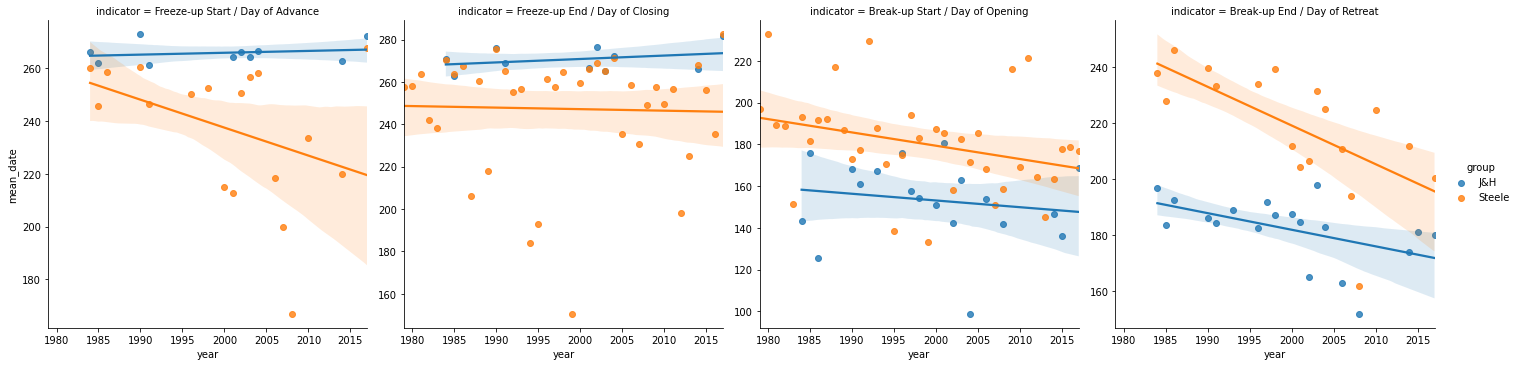

In [7]:
def make_df_from_xy(ds, var_dict, xy_list, group):
    """given an xy_list and variables, make a dataframe by querying an 
    xarray dataset at the given xy locations and aggregating via mean
    """
    # empty list for holding DFs
    df_list = []
    # make a data frame for a single dataset and variable
    with warnings.catch_warnings():
        # ignore "mean of empty slice" warnings
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for var in var_dict.keys():
            df_list.append(
                pd.DataFrame.from_dict(
                    {
                        "indicator": var_dict[var],
                        "year": ds["year"].values,
                        "mean_date": np.nanmean(
                            np.array([
                                ds[var].sel(x=xy[0], y=xy[1], method="nearest").values 
                                for xy in xy_list
                            ]), axis=0),
                        "group": group,
                    }
                )
            )
        
    return pd.concat(df_list)


def get_linreg_results_df(indicators_df, group, loc):
    rows = []
    for indicator, df in indicators_df.groupby(["indicator"]):
        df = df[~np.isnan(df["mean_date"])]
        slope, intercept, r_value, p_value, std_err = stats.linregress(df["year"], df["mean_date"])
        rows.append([loc, group, indicator, round(slope, 1), round(r_value, 2), round(p_value, 3)])
        
    return pd.DataFrame(rows, columns=["location", "group", "indicator", "slope", "r_squared", "p_value"])


# now need to get the xy coords in in 3338, 5398 was for display purposes
transformer = Transformer.from_crs(4326, 3338, always_xy=True)
x,y = transformer.transform(-7.480168, 80.017746)
with rio.open(seamask_fp) as src:
    xy_list = get_xy_from_coords(src, x, y, [(0, 0), (-1, -1), (-1, 0), (0, -1)])



fubu_vars = {
    "freezeup_start": "Freeze-up Start", 
    "freezeup_end": "Freeze-up End", 
    "breakup_start": "Break-up Start",
    "breakup_end": "Break-up End",
}

fubu_df = make_df_from_xy(fubu_3338, fubu_vars, xy_list, "J&H")
fubu_df = fubu_df[fubu_df["year"] <= 2017]


# keep only orac vars, throws error with projection var
# set values to np.nan for reprojection 
orac_vars = {
    "DOA": "Day of Advance", 
    "DOC": "Day of Closing", 
    "DOO": "Day of Opening",
    "DOR": "Day of Retreat",
}

orac_3411 = orac_ds[list(orac_vars.keys())].copy()
for var in orac_vars:
    orac_3411[var].values[orac_3411[var].values < 1] = np.nan 

orac_3411 = orac_3411.rio.write_crs("EPSG:3411").rio.set_spatial_dims("x", "y")
orac_3338 = orac_3411.rio.reproject("EPSG:3338")
# need to restructure for consistent year df
years = np.array([dt.year for dt in orac_3338["time"].values])
orac_3338 = orac_3338.assign_coords(time=years).rename_vars({"time": "year"})

orac_df = make_df_from_xy(orac_3338, orac_vars, xy_list, "Steele")

fubu_results = get_linreg_results_df(fubu_df, "J&H", "Utqiaġvik")
orac_results = get_linreg_results_df(orac_df, "Steele", "Utqiaġvik")

fubu_vars = {
    "freezeup_start": "Freeze-up Start / Day of Advance", 
    "freezeup_end": "Freeze-up End / Day of Closing", 
    "breakup_start": "Break-up Start / Day of Opening",
    "breakup_end": "Break-up End / Day of Retreat",
}
orac_vars = {
    "DOA": "Freeze-up Start / Day of Advance", 
    "DOC": "Freeze-up End / Day of Closing", 
    "DOO": "Break-up Start / Day of Opening",
    "DOR": "Break-up End / Day of Retreat",
}

fubu_df = make_df_from_xy(fubu_3338, fubu_vars, xy_list, "J&H")
orac_df = make_df_from_xy(orac_3338, orac_vars, xy_list, "Steele")
fubu_df = fubu_df[fubu_df["year"] <= 2017]

df = fubu_df.append(orac_df)

sns.set(font_scale=1)
sns.lmplot(x="year", y="mean_date", col="indicator", col_wrap=2, hue="group", data=df, sharey=False)
plt.show()

In [ ]:
get_linreg_results_df(fubu_df, "J&H", "Greenland Sea").append(get_linreg_results_df(orac_df, "Steele", "Greenland Sea"))